In [1]:
#Markov

Intensity values of Hazy Image: [180 182 189]
Intensity values of Restored Image: [149 155 169]


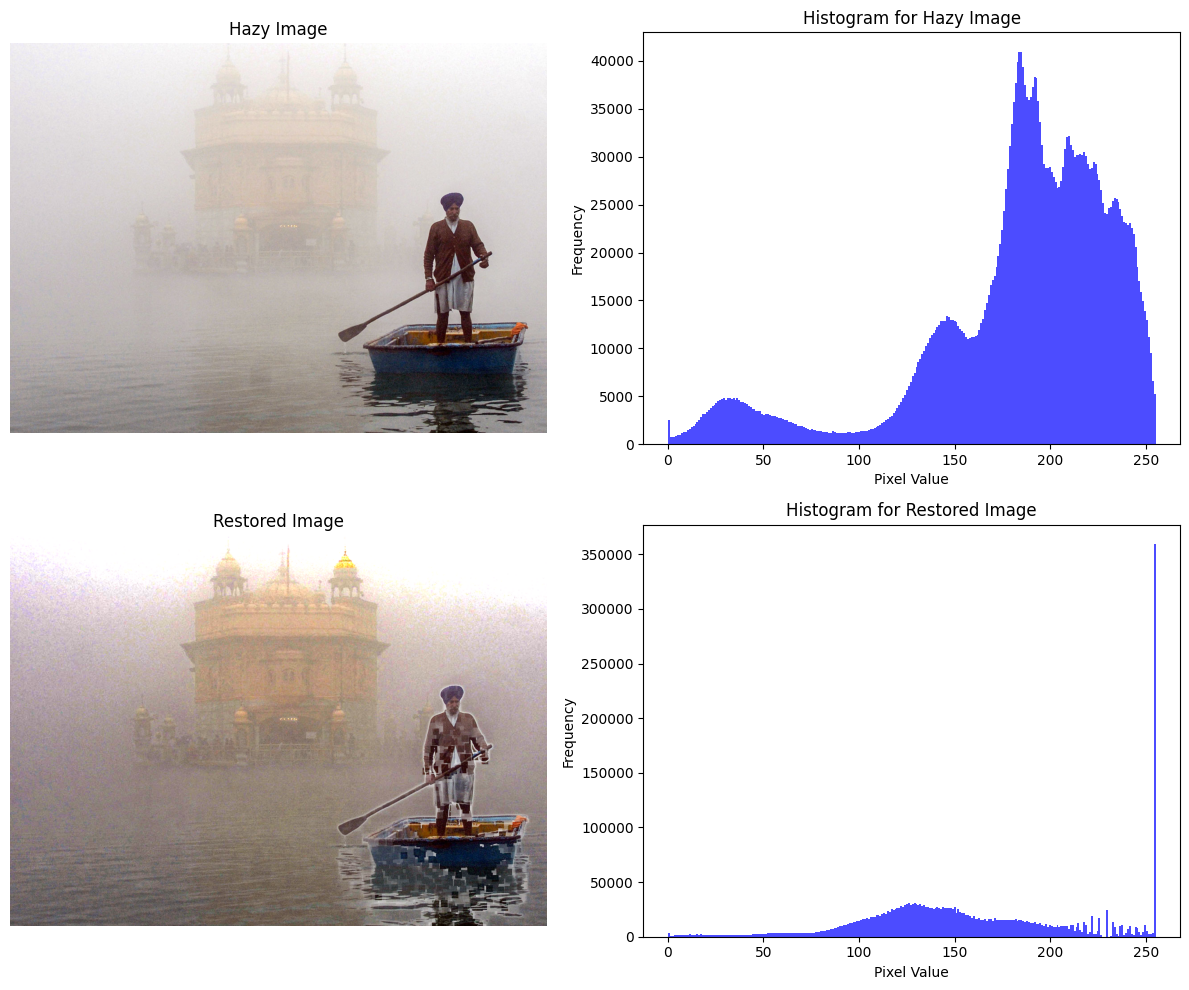

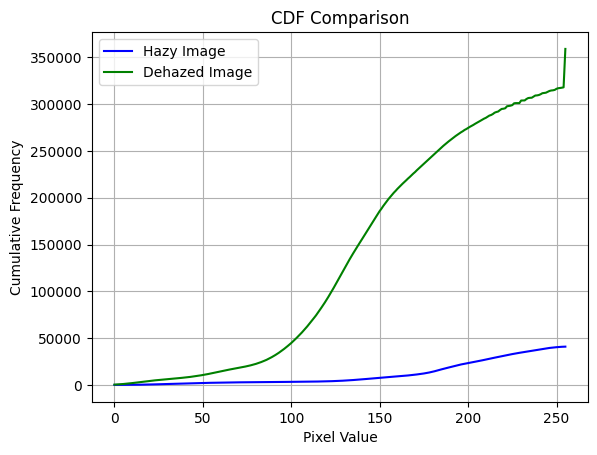

Entropy of Hazy Image: 7.342377592677911
Entropy of Restored Image: 7.154719476371957
Mean Squared Error (MSE) between Hazy and Restored Images: 109.72910907471045
Visibility Metric (VM) of Hazy Image: 23.165888619251557
Visibility Metric (VM) of Restored Image: 38.30674161056875


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_dark_channel(image, patch_size):
    """Compute the dark channel prior of the input image."""
    b, g, r = cv2.split(image)
    min_channel = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    return dark_channel

def estimate_transmission(image, atmosphere, omega, patch_size):
    """Estimate the transmission map using the dark channel prior."""
    I = image.astype(np.float32) / atmosphere.astype(np.float32)
    dark_channel = compute_dark_channel(I, patch_size)
    transmission = 1 - omega * dark_channel
    return transmission

def refine_transmission(image, transmission, beta, iteration):
    """Refine the transmission map using Markov Random Field (MRF)."""
    refined_transmission = transmission.copy()
    for _ in range(iteration):
        refined_transmission = cv2.blur(refined_transmission, (3, 3))
        refined_transmission = np.repeat(refined_transmission[:, :, np.newaxis], 3, axis=2)
        J = image / refined_transmission
        J_dark_channel = compute_dark_channel(J, 15)
        refined_transmission = 1 - beta * (1 - J_dark_channel)
    return refined_transmission

def restore_image(image, atmosphere, omega, beta, patch_size, mrf_iteration):
    """Restore the hazy image using MRF-based dehazing algorithm."""
    transmission = estimate_transmission(image, atmosphere, omega, patch_size)
    refined_transmission = refine_transmission(image, transmission, beta, mrf_iteration)
    
    # Enhance transmission in non-hazy regions to avoid blurring
    restored_transmission = np.maximum(refined_transmission, transmission)
    
    restored_image = np.zeros_like(image, dtype=np.float32)
    for i in range(3):
        transmission_channel = np.maximum(restored_transmission, 0.001)
        restored_image[:, :, i] = (image[:, :, i].astype(np.float32) - atmosphere[i]) / transmission_channel + atmosphere[i]

    restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)
    return restored_image

def cdf(image):
    """Calculate the cumulative distribution function (CDF) of the image."""
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    return cdf_normalized

def entropy(image):
    """Calculate the entropy of the image."""
    hist, _ = np.histogram(image.flatten(), 256, [0, 256])
    hist = hist / np.sum(hist)  # normalize histogram
    entropy_value = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy_value

def mse(image1, image2):
    """Calculate the Mean Squared Error (MSE) between two images."""
    return np.mean((image1 - image2) ** 2)



def visibility_metric(image):
    """Calculate the visibility metric of the image."""
    # Compute the gradient magnitude of the image
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
    
    # Compute the visibility metric by averaging the gradient magnitude
    vm_value = np.mean(gradient_magnitude)
    return vm_value

# Load hazy image
hazy_image = cv2.imread(r"C:\Users\kskor\OneDrive\Desktop\SHRUTI\Sem 6\CV\Project\mandir.jpg")

# Set parameters
if hazy_image is None:
    print("Error: Unable to load the image.")
else:
    omega = 0.98   # Adjust omega to balance haze removal and image appearance
    beta = 0.9    # Adjust beta to control the strength of refinement
    patch_size = 5  # Patch size for dark channel prior
    mrf_iteration = 4  # Number of iterations for MRF-based refinement
    atmosphere = np.array([230, 230, 230])  # Adjust atmosphere color for desired darkness

    # Restore the hazy image
    restored_image = restore_image(hazy_image, atmosphere, omega, beta, patch_size, mrf_iteration)

    # Calculate intensity values of hazy and restored images
    hazy_intensity = np.round(np.mean(hazy_image, axis=(0, 1))).astype(int)
    restored_intensity = np.round(np.mean(restored_image, axis=(0, 1))).astype(int)

    # Display the intensity values
    print("Intensity values of Hazy Image:", hazy_intensity)
    print("Intensity values of Restored Image:", restored_intensity)

    # Plot histograms for hazy image and restored image separately
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot hazy image and its histogram
    axs[0, 0].imshow(cv2.cvtColor(hazy_image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Hazy Image')
    axs[0, 0].axis('off')

    axs[0, 1].hist(hazy_image.ravel(), bins=256, color='blue', alpha=0.7)
    axs[0, 1].set_title('Histogram for Hazy Image')
    axs[0, 1].set_xlabel('Pixel Value')
    axs[0, 1].set_ylabel('Frequency')

    # Plot restored image and its histogram
    axs[1, 0].imshow(cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title('Restored Image')
    axs[1, 0].axis('off')

    axs[1, 1].hist(restored_image.ravel(), bins=256, color='blue', alpha=0.7)
    axs[1, 1].set_title('Histogram for Restored Image')
    axs[1, 1].set_xlabel('Pixel Value')
    axs[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Calculate CDF for hazy and restored images
    hazy_cdf = cdf(hazy_image)
    restored_cdf = cdf(restored_image)

    # Plot CDF for hazy and restored images
    plt.plot(hazy_cdf, color='blue', label='Hazy Image')
    plt.plot(restored_cdf, color='green', label='Dehazed Image')
    plt.title('CDF Comparison')
    plt.xlabel('Pixel Value')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate and print entropy, MSE, contrast, and visibility metric value for hazy and restored images
    hazy_entropy = entropy(hazy_image)
    restored_entropy = entropy(restored_image)
    print("Entropy of Hazy Image:", hazy_entropy)
    print("Entropy of Restored Image:", restored_entropy)

    mse_value = mse(hazy_image, restored_image)
    print("Mean Squared Error (MSE) between Hazy and Restored Images:", mse_value)

   

    hazy_vm = visibility_metric(cv2.cvtColor(hazy_image, cv2.COLOR_BGR2GRAY))
    restored_vm = visibility_metric(cv2.cvtColor(restored_image, cv2.COLOR_BGR2GRAY))
    print("Visibility Metric (VM) of Hazy Image:", hazy_vm)
    print("Visibility Metric (VM) of Restored Image:", restored_vm)


In [3]:
#Riemannian

Intensity values of Hazy Image: [180 182 189]
Intensity values of Dehazed Image: [120 134 158]


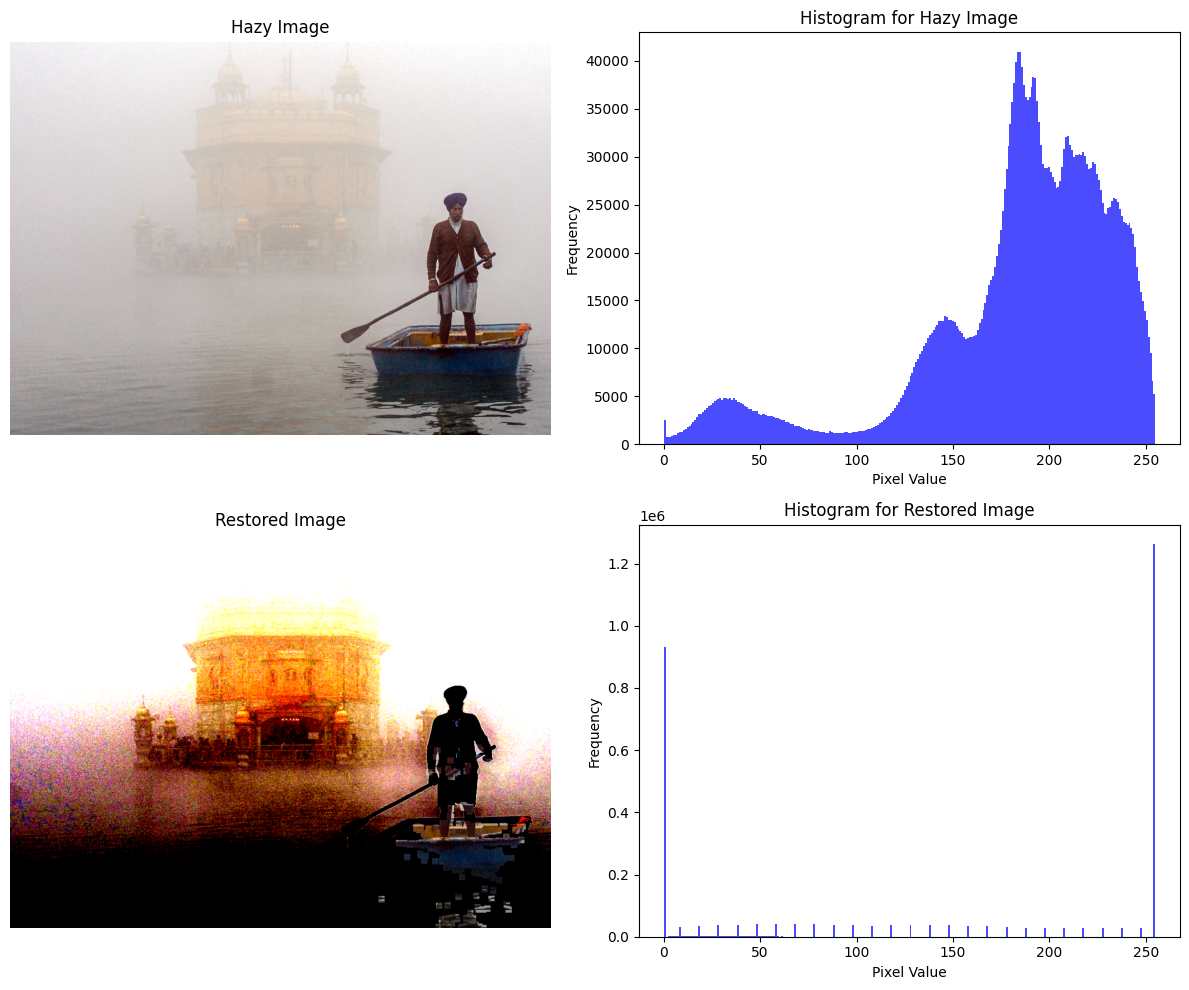

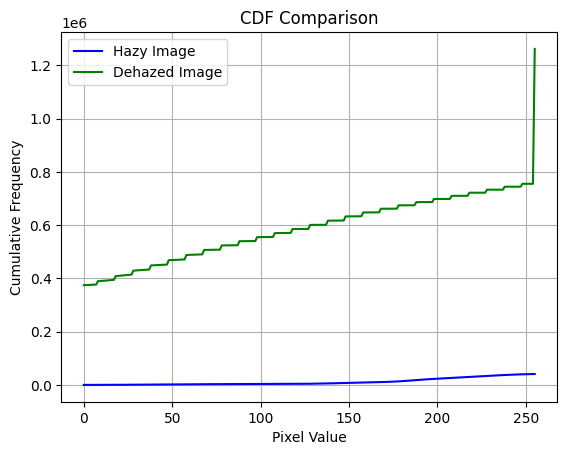

Entropy of Hazy Image: 7.3707839003527535
Entropy of Dehazed Image: 3.0657846533794064
Mean Squared Error (MSE) between Hazy and Dehazed Images: 104.85401266386661
Visibility Metric (VM) of Hazy Image: 24.585836336049297
Visibility Metric (VM) of Dehazed Image: 41.24631739086262


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def dark_channel(image, window_size):
    """Compute the dark channel prior of an image."""
    dark = np.zeros((image.shape[0], image.shape[1], 3))
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Extract window
            window = image[max(0, y - window_size // 2):min(image.shape[0], y + window_size // 2),
                           max(0, x - window_size // 2):min(image.shape[1], x + window_size // 2)]
            # Compute dark channel for each channel separately
            dark[y, x] = np.min(window, axis=(0, 1))
    return dark

def transmission_estimation(dark_channel_image, omega=0.95, window_size=15):
    """Estimate the transmission map using the dark channel prior."""
    return 1 - omega * dark_channel_image

def haze_removal(image, transmission, atmosphere):
    """Remove haze from the image."""
    return (image - atmosphere) / np.maximum(transmission, 0.1) + atmosphere

def visibility_metric(image):
    """Calculate the visibility metric of the image."""
    # Compute the gradient magnitude of the image
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
    
    # Compute the visibility metric by averaging the gradient magnitude
    vm_value = np.mean(gradient_magnitude)
    return vm_value

def main():
    # Load image
    image = cv2.imread(r"C:\Users\kskor\OneDrive\Desktop\SHRUTI\Sem 6\CV\Project\mandir.jpg")  # Provide the correct path to your image
    if image is not None:
        # Convert BGR image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Estimate transmission
        dark_channel_image = dark_channel(image.min(axis=2), window_size=15)
        transmission = transmission_estimation(dark_channel_image)

        # Estimate atmosphere
        atmosphere = np.percentile(image, 55)

        # Remove haze
        dehazed_image = haze_removal(image.astype(float), transmission, atmosphere)

        # Clip values to valid range
        dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)
        
        # Calculate intensity values of hazy and restored images
        hazy_intensity = np.round(np.mean(image, axis=(0, 1))).astype(int)
        restored_intensity = np.round(np.mean(dehazed_image, axis=(0, 1))).astype(int)
        
        # Print intensity values
        print("Intensity values of Hazy Image:", hazy_intensity)
        print("Intensity values of Dehazed Image:", restored_intensity)
        
        # Display the original and dehazed images
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Plot hazy image and its histogram
        axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title('Hazy Image')
        axs[0, 0].axis('off')
    
        axs[0, 1].hist(image.ravel(), bins=256, color='blue', alpha=0.7)
        axs[0, 1].set_title('Histogram for Hazy Image')
        axs[0, 1].set_xlabel('Pixel Value')
        axs[0, 1].set_ylabel('Frequency')
    
        # Plot restored image and its histogram
        axs[1, 0].imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB))
        axs[1, 0].set_title('Restored Image')
        axs[1, 0].axis('off')
    
        axs[1, 1].hist(dehazed_image.ravel(), bins=256, color='blue', alpha=0.7)
        axs[1, 1].set_title('Histogram for Restored Image')
        axs[1, 1].set_xlabel('Pixel Value')
        axs[1, 1].set_ylabel('Frequency')
    
        plt.tight_layout()
        plt.show()
        
        # Calculate CDF for hazy and restored images
        hazy_cdf = cdf(image)
        restored_cdf = cdf(dehazed_image)
    
        # Plot CDF for hazy and restored images
        plt.plot(hazy_cdf, color='blue', label='Hazy Image')
        plt.plot(restored_cdf, color='green', label='Dehazed Image')
        plt.title('CDF Comparison')
        plt.xlabel('Pixel Value')
        plt.ylabel('Cumulative Frequency')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Calculate entropy
        hazy_entropy = entropy(image.min(axis=2))
        dehazed_entropy = entropy(dehazed_image.min(axis=2))
        print("Entropy of Hazy Image:", hazy_entropy)
        print("Entropy of Dehazed Image:", dehazed_entropy)
        
        # Calculate MSE
        mse_value = mse(image, dehazed_image)
        print("Mean Squared Error (MSE) between Hazy and Dehazed Images:", mse_value)
        
        # Calculate visibility metric
        hazy_vm = visibility_metric(image.min(axis=2))
        dehazed_vm = visibility_metric(dehazed_image.min(axis=2))
        print("Visibility Metric (VM) of Hazy Image:", hazy_vm)
        print("Visibility Metric (VM) of Dehazed Image:", dehazed_vm)
        
    else:
        print("Image not found or cannot be loaded.")

if __name__ == "__main__":
    main()


In [5]:
#Combined

Intensity values of Hazy Image: [180 182 189]
Intensity values of Dehazed Image: [ 95 101 114]


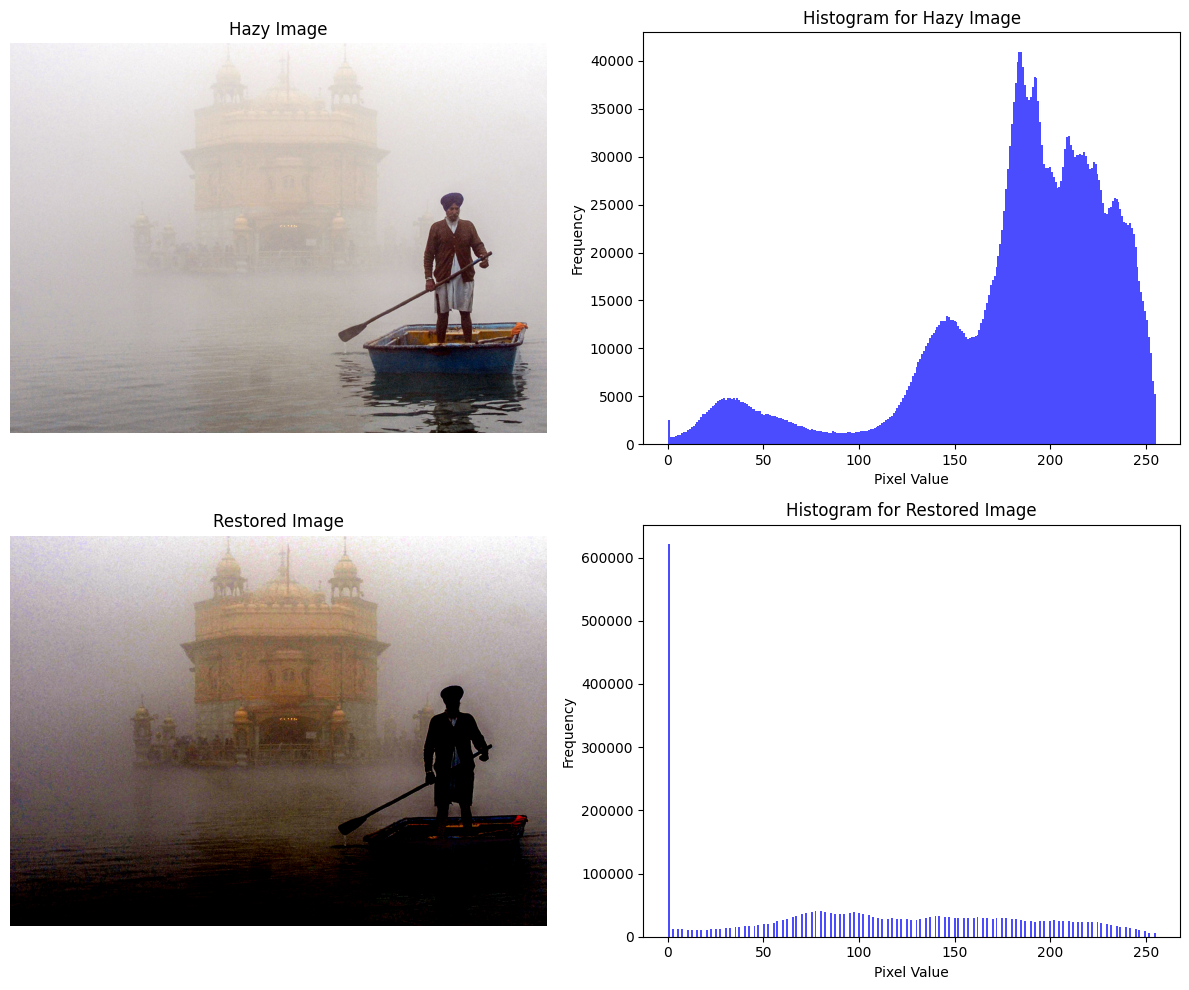

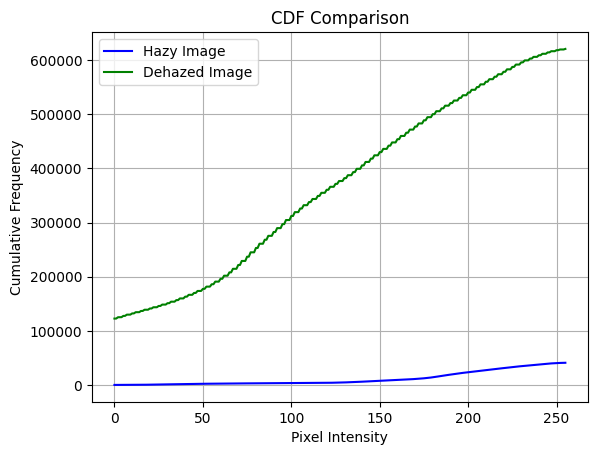

Entropy of Hazy Image: 7.342377592677911
Entropy of Dehazed Image: 6.002155290153559
Mean Squared Error (MSE) between Hazy and Dehazed Images: 109.9323609520173
Visibility Metric (VM) of Hazy Image: 24.585836336049297
Visibility Metric (VM) of Dehazed Image: 29.123806114010122


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(image, window_size):
    """Compute the dark channel prior of an image."""
    dark = np.zeros((image.shape[0], image.shape[1], 3))
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Extract window
            window = image[max(0, y - window_size // 2):min(image.shape[0], y + window_size // 2),
                           max(0, x - window_size // 2):min(image.shape[1], x + window_size // 2)]
            # Compute dark channel for each channel separately
            dark[y, x] = np.min(window, axis=(0, 1))
    return dark

def transmission_estimation(dark_channel_image, omega=0.98):
    """Estimate the transmission map using the dark channel prior."""
    return 1 - omega * dark_channel_image

def guided_filter(image, transmission, radius=40, eps=1e-6):
    """Refine the transmission map using guided filter."""
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    if transmission.dtype != np.float32:
        transmission = transmission.astype(np.float32)
    return cv2.ximgproc.guidedFilter(image, transmission, radius, eps)

def haze_removal(image, transmission, atmosphere):
    """Remove haze from the image."""
    return (image - atmosphere) / np.maximum(transmission, 0.4)[:, :, np.newaxis] + atmosphere

def remove_haze(image, t=0.1, omega=0.8, guided_radius=40):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Estimate the atmospheric light
    dark_channel = np.min(image, axis=2)
    top_pixels = int(dark_channel.size * t)
    flat_dark_channel = dark_channel.flatten()
    indices = np.argpartition(flat_dark_channel, -top_pixels)[-top_pixels:]
    atmospheric_light = np.max(flat_dark_channel[indices])

    # Calculate the transmission map
    transmission_map = transmission_estimation(dark_channel, omega)

    # Refine the transmission map using guided filter
    transmission_map = guided_filter(gray_image, transmission_map, radius=guided_radius)

    # Clip the transmission map
    transmission_map = np.clip(transmission_map, 0.3, 1)

    # Initialize the dehazed image
    dehazed_image = haze_removal(image.astype(float), transmission_map, atmospheric_light)

    # Clip and normalize the dehazed image
    dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)

    return dehazed_image

def cdf(image):
    """Calculate the cumulative distribution function (CDF) of the image."""
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    return cdf_normalized

def entropy(image):
    """Calculate the entropy of the image."""
    hist, _ = np.histogram(image.flatten(), 256, [0, 256])
    hist = hist / np.sum(hist)  # normalize histogram
    entropy_value = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy_value

def mse(image1, image2):
    """Calculate the Mean Squared Error (MSE) between two images."""
    return np.mean((image1 - image2) ** 2)

def visibility_metric(image):
    """Calculate the visibility metric of the image."""
    # Compute the gradient magnitude of the image
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
    
    # Compute the visibility metric by averaging the gradient magnitude
    vm_value = np.mean(gradient_magnitude)
    return vm_value

def main():
    # Load image
    image = cv2.imread(r"C:\Users\kskor\OneDrive\Desktop\SHRUTI\Sem 6\CV\Project\mandir.jpg")  # Provide the correct path to your image
    if image is not None:
        # Remove haze from the image
        dehazed_image = remove_haze(image)
        
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Calculate intensity values of hazy and restored images
        hazy_intensity = np.round(np.mean(image, axis=(0, 1))).astype(int)
        restored_intensity = np.round(np.mean(dehazed_image, axis=(0, 1))).astype(int)
        
        # Print intensity values
        print("Intensity values of Hazy Image:", hazy_intensity)
        print("Intensity values of Dehazed Image:", restored_intensity)
        
        # Display the images
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Plot hazy image and its histogram
        axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title('Hazy Image')
        axs[0, 0].axis('off')
    
        axs[0, 1].hist(image.ravel(), bins=256, color='blue', alpha=0.7)
        axs[0, 1].set_title('Histogram for Hazy Image')
        axs[0, 1].set_xlabel('Pixel Value')
        axs[0, 1].set_ylabel('Frequency')
    
        # Plot restored image and its histogram
        axs[1, 0].imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB))
        axs[1, 0].set_title('Restored Image')
        axs[1, 0].axis('off')
    
        axs[1, 1].hist(dehazed_image.ravel(), bins=256, color='blue', alpha=0.7)
        axs[1, 1].set_title('Histogram for Restored Image')
        axs[1, 1].set_xlabel('Pixel Value')
        axs[1, 1].set_ylabel('Frequency')
    
        plt.tight_layout()
        plt.show()
        
        # Calculate CDF for hazy and dehazed images
        hazy_cdf = cdf(image)
        dehazed_cdf = cdf(dehazed_image)
        
        # Plot CDF
        plt.plot(hazy_cdf, color='blue', label='Hazy Image')
        plt.plot(dehazed_cdf, color='green', label='Dehazed Image')
        plt.title('CDF Comparison')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Cumulative Frequency')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Calculate entropy
        hazy_entropy = entropy(image)
        dehazed_entropy = entropy(dehazed_image)
        print("Entropy of Hazy Image:", hazy_entropy)
        print("Entropy of Dehazed Image:", dehazed_entropy)
        
        # Calculate MSE
        mse_value = mse(image, dehazed_image)
        print("Mean Squared Error (MSE) between Hazy and Dehazed Images:", mse_value)
        
       
        # Calculate visibility metric
        hazy_vm = visibility_metric(image.min(axis=2))
        dehazed_vm = visibility_metric(dehazed_image.min(axis=2))
        print("Visibility Metric (VM) of Hazy Image:", hazy_vm)
        print("Visibility Metric (VM) of Dehazed Image:", dehazed_vm)
        
    else:
        print("Image not found or cannot be loaded.")

if __name__ == "__main__":
    main()
